In [12]:
from func import ShopeeDataset, device, torch, np, f1_score_cal, display_df, path, get_data, path_img
from tqdm import tqdm
import faiss
from sklearn.model_selection import train_test_split

In [2]:
# input
df = get_data(path / 'train.csv')
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2278313361, train_129225211]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3386243561, train_3423213080]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2288590299, train_3803689425]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3342059966, train_2406599165]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_3369186413, train_921438619]",nescafe \xc3\x89clair latte 220ml


In [19]:
len(df.label_group.unique())

11014

In [24]:
import os
idx = str(1%11014 + 1)
os.path.join(str(path_img), idx)

'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\2'

In [ ]:
class TripletData(Dataset):
    def __init__(self, path, transforms, split="train"):
        self.path = path
        self.split = split    # train or valid
        self.cats = 11014       # number of categories
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # our positive class for the triplet
        idx = str(idx%self.cats + 1)
        
        # choosing our pair of positive images (im1, im2)
        positives = os.listdir(os.path.join(self.path, idx))
        im1, im2 = random.sample(positives, 2)
        
        # choosing a negative class and negative image (im3)
        negative_cats = [str(x+1) for x in range(self.cats)]
        negative_cats.remove(idx)
        negative_cat = str(random.choice(negative_cats))
        negatives = os.listdir(os.path.join(self.path, negative_cat))
        im3 = random.choice(negatives)
        
        im1,im2,im3 = os.path.join(self.path, idx, im1), os.path.join(self.path, idx, im2), os.path.join(self.path, negative_cat, im3)
        
        im1 = self.transforms(Image.open(im1))
        im2 = self.transforms(Image.open(im2))
        im3 = self.transforms(Image.open(im3))
        
        return [im1, im2, im3]
        
    # we'll put some value that we want since there can be far too many triplets possible
    # multiples of the number of images/ number of categories is a good choice
    def __len__(self):
        return self.cats*8
    

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train, valid = train_test_split(df.filepath.values, test_size=0.2, random_state=42)

# Datasets and Dataloaders
train_data = TripletData(PATH_TRAIN, train_transforms)
val_data = TripletData(PATH_VALID, val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=32, shuffle=False, num_workers=2)

In [18]:
train

array(['C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\bf69ead3dadbf3ebe850b1d34314eafe.jpg',
       'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\d61504756b83762c5128a19383566dc6.jpg',
       'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\31803e68b56c10a0c745140122f9498f.jpg',
       ...,
       'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\54d9ac90baa0084f1246256b4beddb2b.jpg',
       'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\06cca2d5f8beefd8d73dd4405de09cf7.jpg',
       'C:\\Users\\PC\\OneDrive - Seagroup\\computer_vison\\shopee_item_images\\train_images\\76d21ae7b32f3f437ecb91f44c09f735.jpg'],
      dtype=object)

In [3]:
image_embeddings_path = path / 'all_image_embeddings.npy'
all_image_embeddings = np.load(image_embeddings_path)

In [4]:
faiss_index = faiss.IndexFlatL2(1000)

im_indices = []
for i, v in tqdm(enumerate(all_image_embeddings), total=all_image_embeddings.shape[0]):
    faiss_index.add(v.reshape(1, 1000))
    im_indices.append(i)

100%|████████████████████████████████████████████████████████████████████████| 34250/34250 [00:00<00:00, 285415.80it/s]


In [27]:
for i, v in tqdm(enumerate(all_image_embeddings), total=all_image_embeddings.shape[0]):
    index = np.where(distances[k, ] < 21.0)[0]
    split = indices[k, index]
    pred = df.iloc[split]['posting_id'].values.tolist()
    predictions.append(pred)

array([[    0, 33042,  3963, 17471,  5831]], dtype=int64)

In [8]:
_, I = faiss_index.search(all_image_embeddings[0].reshape(1, 1000), 5)
I

array([[    0, 33042,  3963, 17471,  5831]], dtype=int64)

In [10]:
df.iloc[I[0]]

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2278313361, train_129225211]",paper bag victoria secret
33042,train_1484111914,f74b03ec6dd964734283ea7159f130e3.jpg,df1e322f61d21a68,1209 Best Seller ERENA Jumbo Jegging // CANTIQUE,3047942142,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_1484111914, train_2029861382, train_146...",1209 best seller erena jumbo jegging // cantique
3963,train_1844994299,1e191b366374dd106e0a0c0921d53538.jpg,a2f828fb08fa28fa,PAMPERS Baby Diapers S 48 - Tape,1041068707,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_697383278, train_1328162672, train_2536...",pampers baby diapers s 48 - tape
17471,train_4055110061,8381182c51086000d852d15a3223604d.jpg,bacdc462a70b4f86,LETICIA - Setelan Baju Muslim Anak Cewek Usia ...,1274738046,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_2705159396, train_43123445, train_19582...",leticia - setelan baju muslim anak cewek usia ...
5831,train_443787474,2c07bff5e79888e192ec92fafb891da2.jpg,bfc0c618f1a78972,Garnier Colour Naturals Hair Colour Cream Sach...,2910074820,C:\Users\PC\OneDrive - Seagroup\computer_vison...,"[train_25803842, train_2829521104, train_39522...",garnier colour naturals hair colour cream sach...


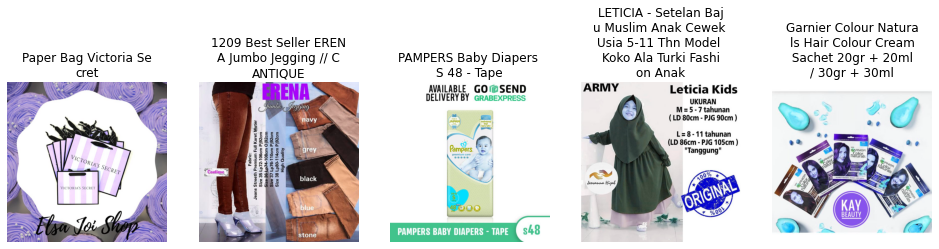

In [13]:
test_id = 'train_129225211'
tmp = df.iloc[I[0]]

display_df(tmp, path_img)